In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display

In [3]:
torch.cuda.empty_cache()

### Loading the dataset

set up dataloader

In [7]:
path = '/home/ubuntu/datasets/processed/mixer/2-20000-2/test';
d = ds.SignalDataset(root_dir=path, transform=ds.Concat(size=(129, 231)))
# d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))

In [30]:
dataloader = torch.utils.data.DataLoader(d, batch_size=4, shuffle=False)

In [31]:
for i, info in enumerate(dataloader):
    print(i)
    aggregate = info['aggregate']
#     ground_truths_in = info['ground_truths_in']
#     ground_truths_gt = info['ground_truths_gt']
    ground_truths = info['ground_truths']
    
    break

_, seq_len, input_dim = aggregate.shape
print(aggregate.shape)
print(ground_truths.shape)
# print(ground_truths_in.shape)
# print(ground_truths_gt.shape)

0
torch.Size([4, 231, 258])
torch.Size([4, 231, 2, 258])


In [32]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)
    
def get_spect(data, fs, nperseg, noverlap):
    r = np.split(data.numpy().T, 2)[0]
    i = np.split(data.numpy().T, 2)[1]
    c = r + 1j * i
    
    rev = scipy.signal.istft(c, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return c, rev

def get_spects(ground_truths, fs, nperseg, noverlap, xid=0):
    _, seq_len, nsource, input_dim = ground_truths.shape
    
    c_gts = []
    revs = []
    for i in range(nsource):
        gt = ground_truths[xid, :, i].cpu()
        c_gt, rev = get_spect(gt, fs, nperseg, noverlap)

        c_gts.append(c_gt)
        revs.append(rev)
    
    return c_gts, revs

visualize sample data

In [61]:
xid = 2
nsource = 2
fs = 22050
nperseg = 256
noverlap = nperseg // 4
agg_sample = aggregate[xid]
c_agg, agg_data = get_spect(agg_sample, fs=fs, nperseg=nperseg, noverlap=noverlap)
cgts, revs = get_spects(ground_truths, fs=fs, nperseg=nperseg, noverlap=noverlap, xid=xid)

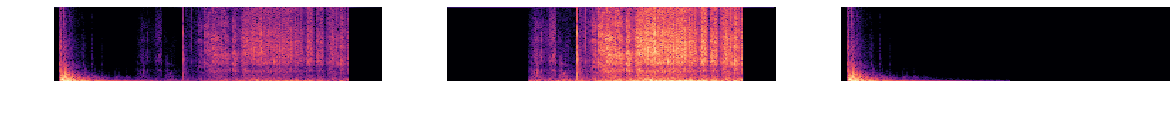

In [62]:
fig = plt.figure(figsize=(20, 3))
cs = [c_agg] + cgts
for i, c in enumerate(cs):
    plt.subplot(2, 3, i + 1)
    display(c, fs)
    plt.axis('off')

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [73]:
import model.transformer
_, seq_len, input_dim = aggregate.shape
print(seq_len)
print(input_dim)
# net = model.transformer.make_model(freq_range).to(device)
net = model.models.B1(input_dim=input_dim,
                        seq_len=seq_len,
                        hidden_size=100,
                        num_sources=2).to(device)

checkpoint = torch.load('/home/ubuntu/multimodal-listener/results/2-20000-2_euclidean_LSTM_190713/config_4/snapshots/best.tar')

net.load_state_dict(checkpoint['model_state_dict'])

231
258


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [74]:
preds = net(aggregate.to(device))
# preds = net(aggregate.to(device), ground_truths.to(device), None, subseq_mask)
print(aggregate.shape)
print(preds.shape)
# preds2, _ = net2(aggregate)

torch.Size([4, 231, 258])
torch.Size([4, 231, 2, 258])


In [75]:
cgts, revs = get_spects(preds.detach(), fs=fs, nperseg=nperseg, noverlap=noverlap, xid=xid)

In [78]:
IPython.display.Audio(data=agg_data, rate=fs)

predicted separations

In [79]:
IPython.display.Audio(data=revs[0], rate=fs)

In [80]:
IPython.display.Audio(data=revs[1], rate=fs)

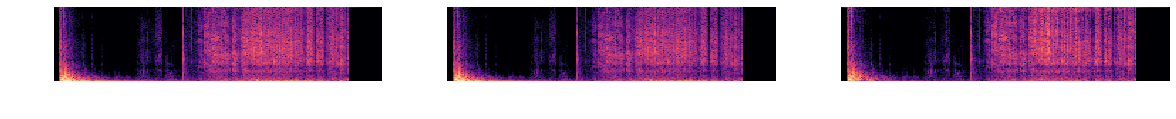

In [77]:
fig = plt.figure(figsize=(20, 3))
cs = [c_agg] + cgts
for i, c in enumerate(cs):
    plt.subplot(2, 3, i + 1)
    display(c, fs)
    plt.axis('off')